# Machine Learning Project for Student Depression Data Set

*A student depression dataset typically contains data aimed at analyzing, understanding, and predicting depression levels among students. It may include features such as demographic information (age, gender), academic performance (grades, attendance), lifestyle habits (sleep patterns, exercise, social activities), mental health history, and responses to standardized depression scales. - Data from [Kaggle](https://www.kaggle.com/datasets/hopesb/student-depression-dataset)*

In this notebook, we will create some classifiers. Let's start with this part where we will examine and preprocess the data set.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print('All imports were successful!')

All imports were successful!


Create the data set variable.

In [2]:
df = pd.read_csv('/kaggle/input/student-depression-dataset/Student Depression Dataset.csv')
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


<code>id</code> column is not necessary of our project. Let's remove it from our <code>df</code> variable.

In [3]:
df.drop(['id'], axis=1, inplace=True)

So, wonderful! In our data set, we have some columns with categorical data. But for machine learning process, we do not want them. Algorithms we will use require numeric data. So, let's convert our categorical features.

In [4]:
def convert_column_to_numeric(df, col):
    # Create a dict
    unique_values = df[col].unique()
    value_to_number = {value: idx + 1 for idx, value in enumerate(unique_values)}

    # Convert column
    df[col] = df[col].map(value_to_number)

    return df, value_to_number

In [5]:
# Convert categorical data
convert_column_to_numeric(df, 'Gender')
convert_column_to_numeric(df, 'Profession')
convert_column_to_numeric(df, 'Dietary Habits')
convert_column_to_numeric(df, 'Degree')
convert_column_to_numeric(df, 'Have you ever had suicidal thoughts ?')
convert_column_to_numeric(df, 'Family History of Mental Illness')
convert_column_to_numeric(df, 'City')

df.head()

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,1,33.0,1,1,5.0,0.0,8.97,2.0,0.0,5-6 hours,1,1,1,3.0,1.0,1,1
1,2,24.0,2,1,2.0,0.0,5.90,5.0,0.0,5-6 hours,2,2,2,3.0,2.0,2,0
2,1,31.0,3,1,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,1,3,2,9.0,1.0,2,0
3,2,28.0,4,1,3.0,0.0,5.59,2.0,0.0,7-8 hours,2,4,1,4.0,5.0,2,1
4,2,25.0,5,1,4.0,0.0,8.13,3.0,0.0,5-6 hours,2,5,1,1.0,1.0,1,0


For <code>Sleep Duration</code> column, it is good to convert it as *certain* values.

In [6]:
# Convert from string to float
convert = {
    '5-6 hours': 5.5,
    'Less than 5 hours': 4.5,
    '7-8 hours': 7.8,
    'More than 8 hours': 8.5,
    'Others': 0
}

df['Sleep Duration'] = df['Sleep Duration'].map(convert)
df['Sleep Duration'] = df['Sleep Duration'].astype(float)
df['Sleep Duration'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 27901 entries, 0 to 27900
Series name: Sleep Duration
Non-Null Count  Dtype  
--------------  -----  
27901 non-null  float64
dtypes: float64(1)
memory usage: 218.1 KB


We made our data full with numerical variables so far. Let's control it.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  int64  
 1   Age                                    27901 non-null  float64
 2   City                                   27901 non-null  int64  
 3   Profession                             27901 non-null  int64  
 4   Academic Pressure                      27901 non-null  float64
 5   Work Pressure                          27901 non-null  float64
 6   CGPA                                   27901 non-null  float64
 7   Study Satisfaction                     27901 non-null  float64
 8   Job Satisfaction                       27901 non-null  float64
 9   Sleep Duration                         27901 non-null  float64
 10  Dietary Habits                         27901 non-null  int64  
 11  De

Our everything is good now. If we do not have any empty cell in our data, we can continue to machine learning part.

In [8]:
df.isna().sum()

Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

There are some empty cells... Let's drop them.

In [9]:
df = df.dropna()
df.isna().sum()

Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

Right now, we have not any empty cell.

## Machine Learning

In this part of the project, we will create some machine learning models that will classify our students if they have depression or not. Our classifiers will be:

* Decision Tree
* Random Forest
* Extra Randomized Trees
* LightGBM
* AdaBoost

For finding the best parameters, we will train <code>GridSearchCV</code>. Let's start with splitting our data

In [10]:
# Split the data
X = df.drop('Depression', axis=1)
y = df['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

Train <code>Decision Tree Classifier</code>.

In [11]:
# Create parameters
params = {'criterion': ['gini', 'log_loss', 'entropy'],
          'max_depth': [None, 5, 10, 15, 20],
          'min_samples_split': [2, 4, 5, 7, 9],
          'min_samples_leaf': [1, 2, 4, 5, 6]}

# Train a GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)

# Train Decision Tree classifier
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = dtc.predict(X_test)

# Evaluate its performance
dtc_accuracy = accuracy_score(y_test, y_hat)
dtc_recall = recall_score(y_test, y_hat, average='weighted')
dtc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {dtc_accuracy}
Recall Score: {dtc_recall}
F1 Score: {dtc_f1}''')

Accuracy Score: 0.8245519713261649
Recall Score: 0.8245519713261649
F1 Score: 0.8250522601063395


We will talk about performances later. Let's continue with <code>Random Forest Classifier</code>.

In [12]:
# Train Random Forest Classifier
rfc = RandomForestClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = rfc.predict(X_test)

# Evaluate its performance
rfc_accuracy = accuracy_score(y_test, y_hat)
rfc_recall = recall_score(y_test, y_hat, average='weighted')
rfc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {rfc_accuracy}
Recall Score: {rfc_recall}
F1 Score: {rfc_f1}''')

Accuracy Score: 0.8381720430107527
Recall Score: 0.8381720430107527
F1 Score: 0.8370245663052226


Train an <code>Extra Trees Classifier</code>.

In [13]:
# Train an Extra Trees Classifier and make predictions
etc = ExtraTreesClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = etc.predict(X_test)

# Evaluate the performance
etc_accuracy = accuracy_score(y_test, y_hat)
etc_recall = recall_score(y_test, y_hat, average='weighted')
etc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {etc_accuracy}
Recall Score: {etc_recall}
F1 Score: {etc_f1}''')

Accuracy Score: 0.8197132616487455
Recall Score: 0.8197132616487455
F1 Score: 0.8177244391690462


Train a <code>LightGBM</code>.

In [14]:
# Create parameters and train a GridSearchCV
params = {
    'num_leaves': [7, 15, 31],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, -1],
    'min_child_samples': [10, 20, 30]
}

grid = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=5).fit(X_train, y_train)

# Train a LightGBM and make predictions
lgb_model = lgb.LGBMClassifier(**grid.best_params_, verbose=-1).fit(X_train, y_train)
y_hat = lgb_model.predict(X_test)

# Evaluate the performance
lgb_accuracy = accuracy_score(y_test, y_hat)
lgb_recall = recall_score(y_test, y_hat, average='weighted')
lgb_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {lgb_accuracy}
Recall Score: {lgb_recall}
F1 Score: {lgb_f1}''')

Accuracy Score: 0.8492831541218638
Recall Score: 0.8492831541218638
F1 Score: 0.8489052656301938


Train an <code>AdaBoost Classifier</code>.

In [15]:
# Create parameters and train a GridSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier()), params, cv=5).fit(X_train, y_train)

# Train an AdaBoost Classifier and make predictions
abc = AdaBoostClassifier(estimator=DecisionTreeClassifier(), **grid.best_params_).fit(X_train, y_train)
y_hat = abc.predict(X_test)

# Evaluate the performance
abc_accuracy = accuracy_score(y_test, y_hat)
abc_recall = recall_score(y_test, y_hat, average='weighted')
abc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {abc_accuracy}
Recall Score: {abc_recall}
F1 Score: {abc_f1}''')

Accuracy Score: 0.7711469534050179
Recall Score: 0.7711469534050179
F1 Score: 0.7713048092895549


We created all of our classifiers! For selecting the best model, let's create a graph and see performance evaluation. After that, we can select the best model.

In [16]:
# Create scores dictionary
scores = {'Decision Tree': [dtc_accuracy, dtc_recall, dtc_f1],
          'Extra Randomized Trees': [etc_accuracy, etc_recall, etc_f1],
          'Random Forest': [rfc_accuracy, rfc_recall, rfc_f1],
          'LightGBM': [lgb_accuracy, lgb_recall, lgb_f1],
          'AdaBoost': [abc_accuracy, abc_recall, abc_f1]
}

# Create the data frame and show it
scores_table = pd.DataFrame(scores)
scores_table.index = ['Accuracy', 'Recall', 'F1']
scores_table.head()

,Decision Tree,Extra Randomized Trees,Random Forest,LightGBM,AdaBoost
Accuracy,0.824552,0.819713,0.838172,0.849283,0.771147
Recall,0.824552,0.819713,0.838172,0.849283,0.771147
F1,0.825052,0.817724,0.837025,0.848905,0.771305


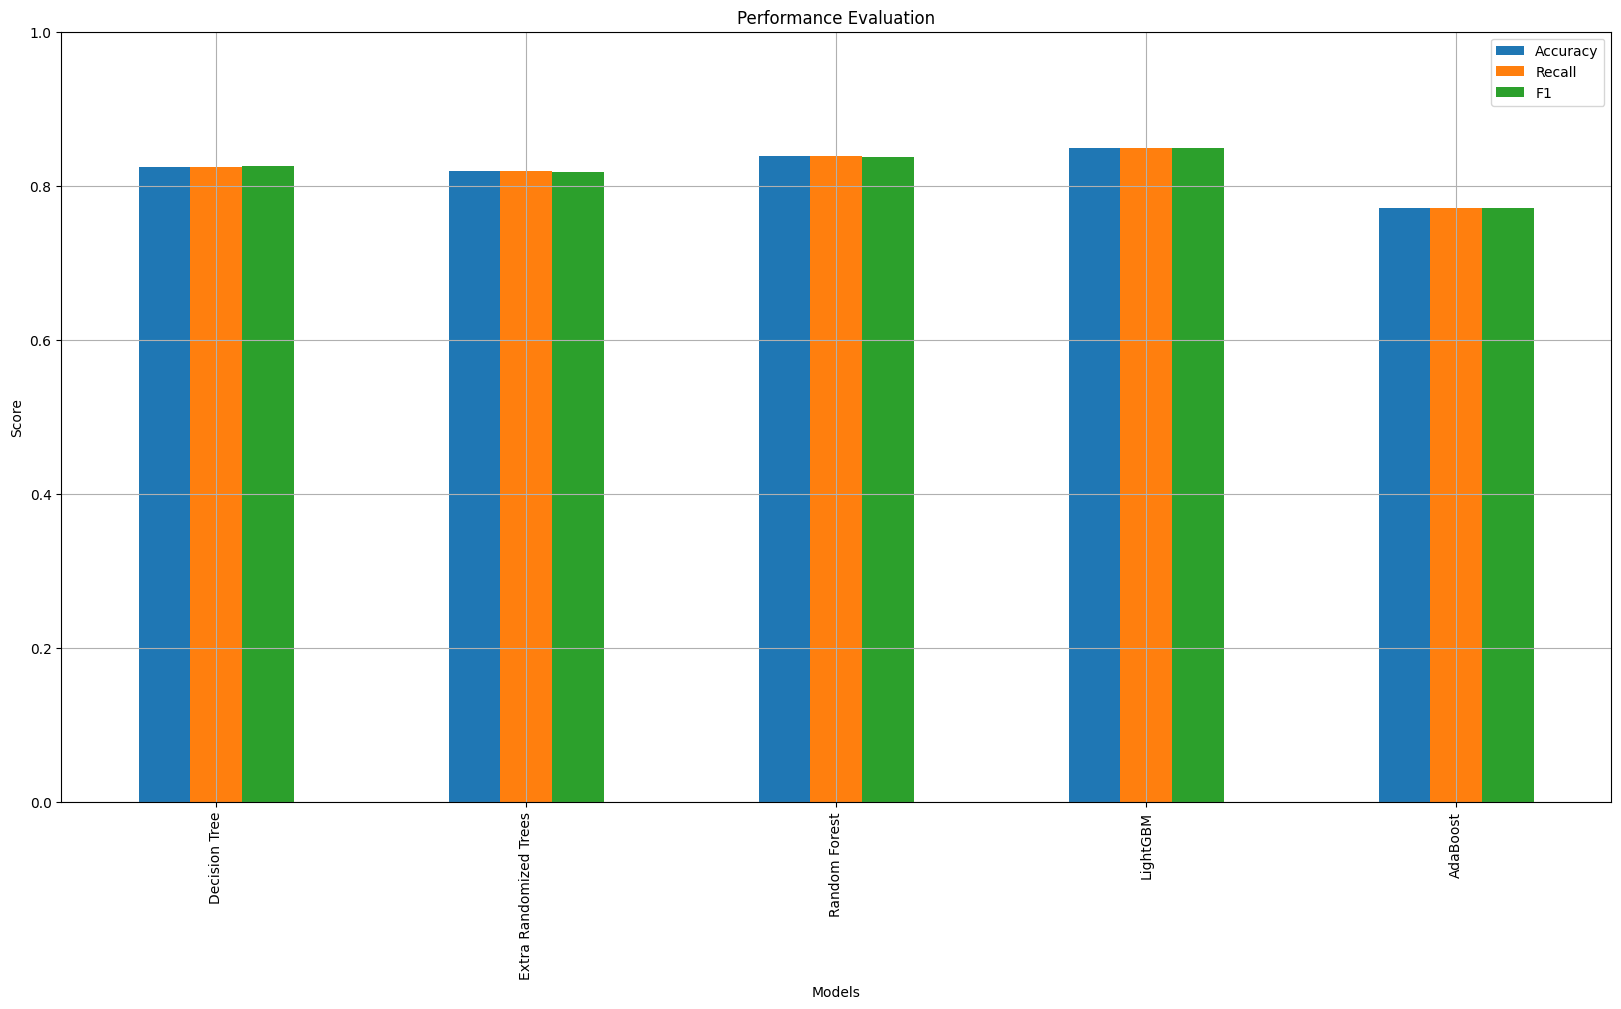

In [17]:
# Create and show the graph
scores_table.T.plot(kind='bar', figsize=(20, 10))
plt.title('Performance Evaluation')
plt.xlabel('Models')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.grid()
plt.show()

From results, you can see that we generally have scores above 80%. Our models are successful generally. But for my case (when I run my notebook), I can see that, the best performance came from <code>LightGBM Classifier</code>. So, we can choose this model for this case. So, this project finishes here. Hope that it will help to the future projects.

Feel free if you want to contribute this project.

### Thank you.

#### Mert Kont (Author of the Project)